<img src="https://www.epfl.ch/about/overview/wp-content/uploads/2020/07/logo-epfl-1024x576.png"
    style="padding-right:10px;width:140px;float:left">
<h2 style="white-space: nowrap">Neural Signal and Signal Processing (NX-421)</h2>
<hr style="clear:both">
<h1 style="colr:black">Miniproject 2 - Processing and analysis of EMG data</h1>
<h1 style="colr:black">Part 1</h1>
<h4 style="white-space: nowrap">Camille Dorster, Toufan Kashaev, Johan Bordet</h4>

In [17]:
import numpy as np
from scipy.io import loadmat
from scipy.signal import butter, sosfiltfilt
from scipy.ndimage import convolve1d
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.decomposition import PCA
import seaborn as sns
import os

np.random.seed(42)
random_state = 42

# --- load S2_A1_E1 ---
data_folder_name = "Data"
subject_folder_name = "s2"
subject_data_name = "S2_A1_E1.mat"
subject_data_path = os.path.join(data_folder_name, subject_folder_name, subject_data_name)

data = loadmat(subject_data_path)

emg       = data["emg"]                    # (T, n_channels)
stimulus  = data["restimulus"].ravel()     # corrected labels, 1D
repetition = data["rerepetition"].ravel()  # repetition indices, 1D

print("EMG shape:", emg.shape)
print("Unique stimulus labels:", np.unique(stimulus))
print("Unique repetition labels:", np.unique(repetition))

# NinaPro DB1 EMG sampling freq
fs = 100  # Hz

EMG shape: (100686, 10)
Unique stimulus labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Unique repetition labels: [ 0  1  2  3  4  5  6  7  8  9 10]


## 1. Visualize & preprocess

In [19]:
def remove_local_spikes(
    emg,
    window_size=25,
    threshold=4.0,
    replace_strategy="median"):
    """
    Suppress sharp outliers based on local MAD in a sliding window (pre-filter).
    
    Parameters
    ----------
    emg : ndarray, shape (T, C)
        Raw EMG signal (time × channels).
    window_size : int
        Number of samples for local window (e.g. 25 for 250 ms at 100 Hz).
    threshold : float
        How many scaled MADs away from the local median counts as an outlier.
    replace_strategy : "median" or "interp"
        How to replace outliers: with local median or interpolation.

    Returns
    -------
    emg_clean : ndarray
        Denoised EMG with local spikes replaced.
    """
    T, C = emg.shape
    half_w = window_size // 2
    emg_clean = emg.copy().astype(float)

    for ch in range(C):
        x = emg[:, ch]
        x_clean = x.copy()

        for t in range(T):
            i0 = max(0, t - half_w)
            i1 = min(T, t + half_w + 1)
            segment = x[i0:i1]
            med = np.median(segment)
            mad = np.median(np.abs(segment - med)) + 1e-12
            scaled_mad = 1.4826 * mad
            # Test if current sample is an outlier
            if np.abs(x[t] - med) > threshold * scaled_mad:
                if replace_strategy == "median":
                    x_clean[t] = med
                elif replace_strategy == "interp" and 1 < t < T - 2:
                    x_clean[t] = (x[t-1] + x[t+1]) / 2  # simple linear
                else:
                    x_clean[t] = med  # fallback

        emg_clean[:, ch] = x_clean

    return emg_clean

def bandpass_emg(emg, fs, bp=(5, 45)):
    """4th order Butterworth band-pass for DB1 EMG (100 Hz RMS-coded)."""
    sos_bp = butter(N=4, Wn=bp, fs=fs, btype="bandpass", output="sos")
    emg_filt = sosfiltfilt(sos_bp, emg.T).T
    return emg_filt


def rectified_envelope(emg_filt, window_samples=25):
    """Full-wave rectification + moving average envelope."""
    emg_rect = np.abs(emg_filt)
    w = np.ones(window_samples) / window_samples
    emg_env = convolve1d(emg_rect, w, axis=0, mode="nearest")
    return emg_env


In [20]:
# Remove outliers using MAD-based sliding window
emg_denoised = remove_local_spikes(emg, window_size=100, threshold=4.0)
# Band-pass filter first (remove drift + HF noise)
emg_filt = bandpass_emg(emg_denoised, fs)
# Rectify + smooth (envelope extraction)
emg_env = rectified_envelope(emg_filt, window_samples=25)


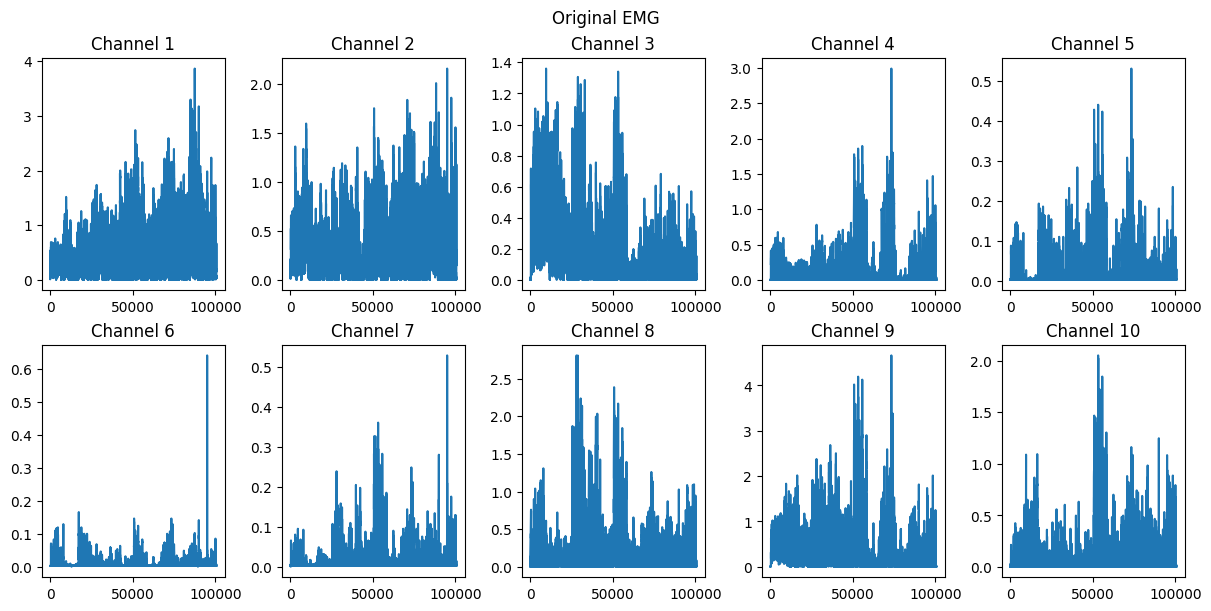

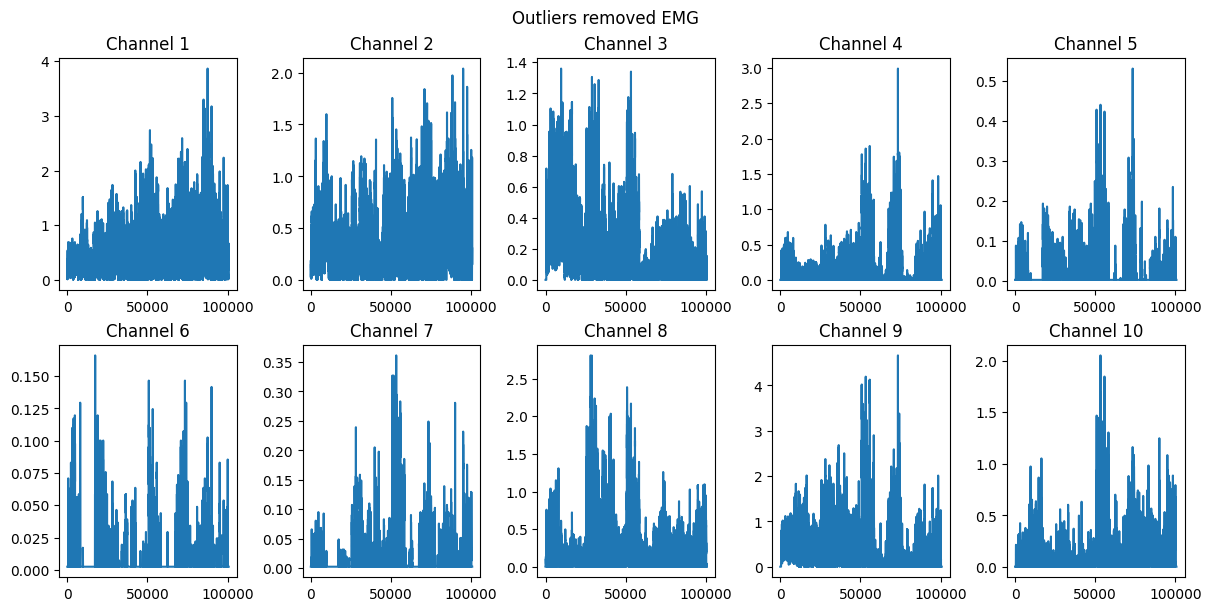

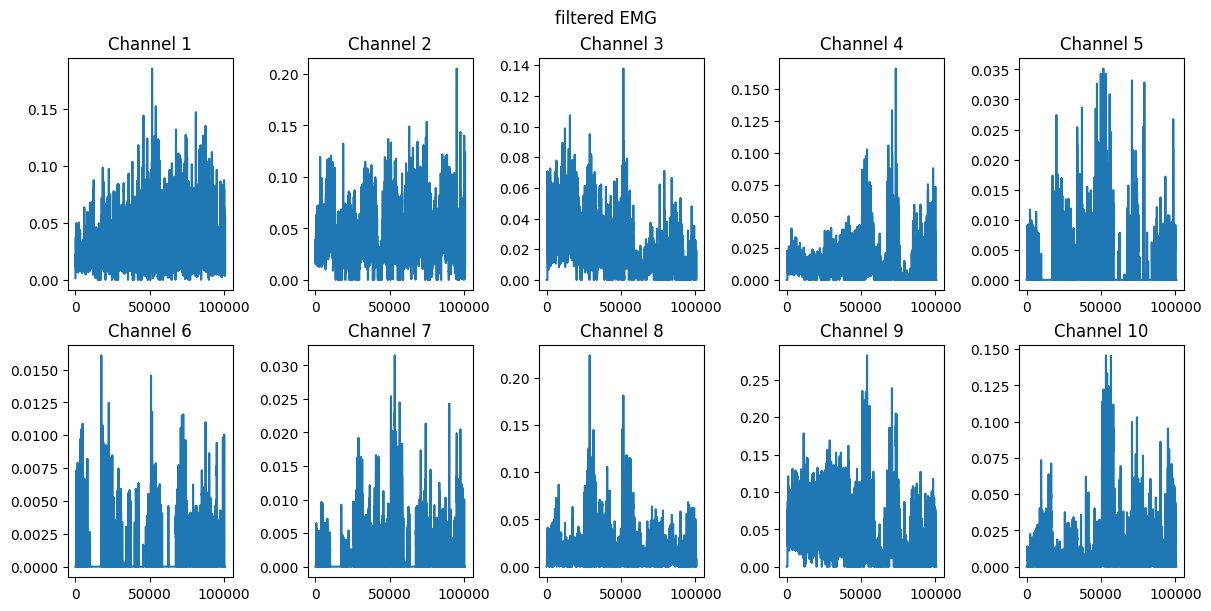

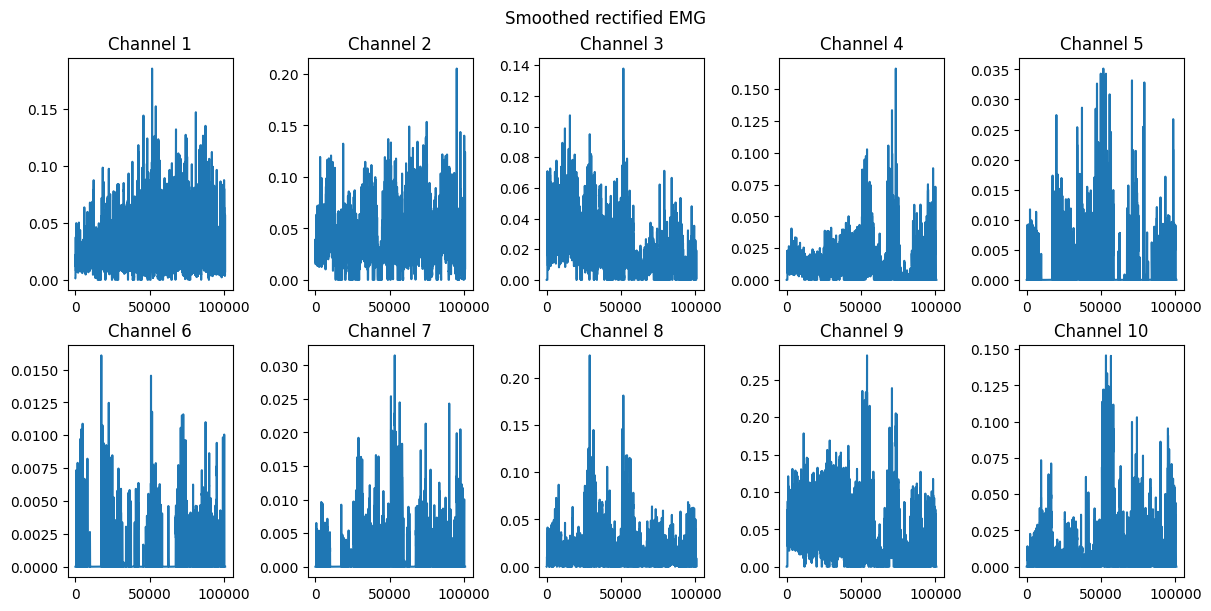

In [21]:
plt.close("all")

#10 EMG channels
number_of_emg_channels = emg.shape[-1]
signals = [emg, emg_denoised, emg_env, emg_env]
names = ["Original EMG", "Outliers removed EMG", "filtered EMG", "Smoothed rectified EMG"]

for i, _ in enumerate(signals):
    # plot Envelopes of the EMG signal
    fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True)
    ax = ax.ravel()
    for channel_idx in range(number_of_emg_channels): 
        ax[channel_idx].plot(signals[i][:, channel_idx])
        ax[channel_idx].set_title(f"Channel {channel_idx+1}")
    plt.suptitle(names[i])

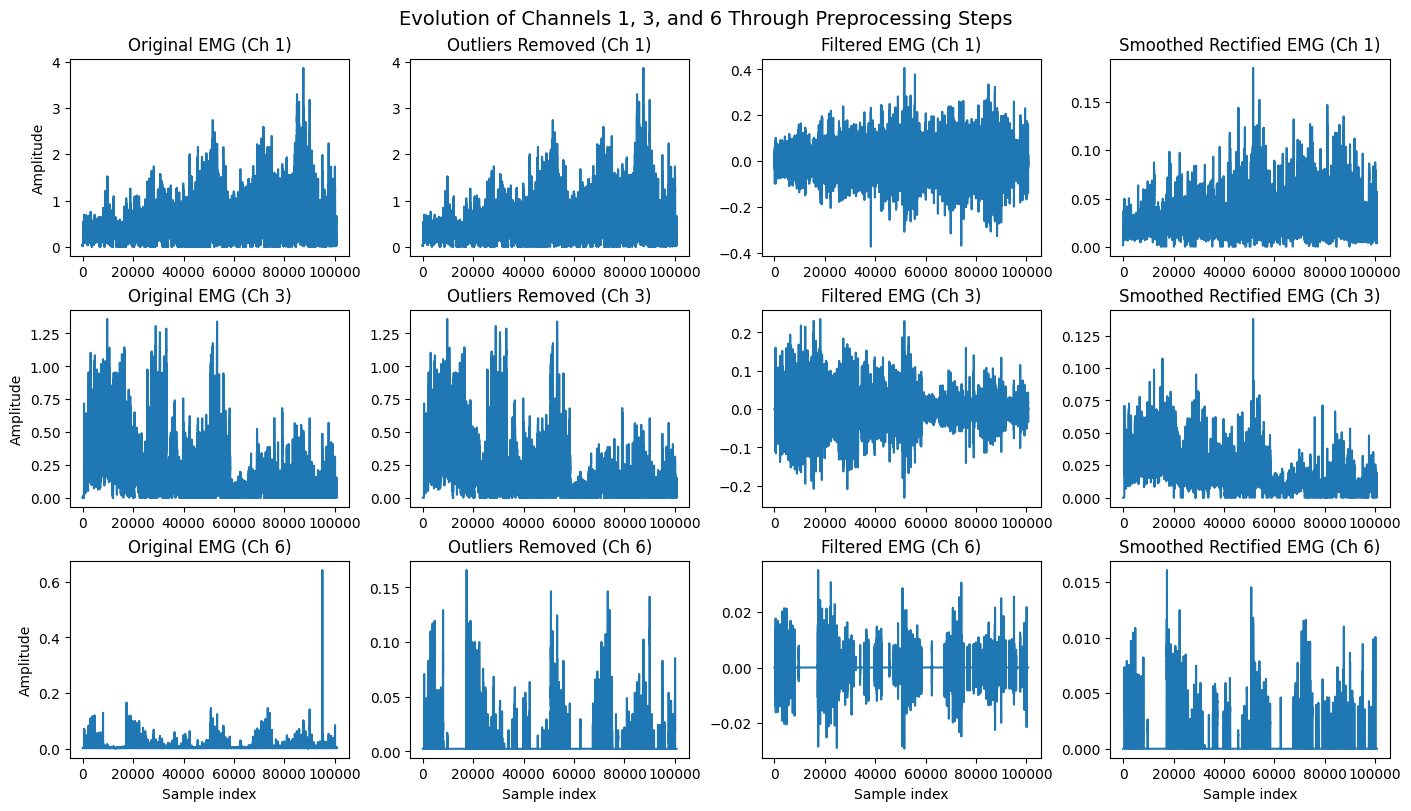

In [22]:
import matplotlib.pyplot as plt

# Define EMG signals at each stage
signals = [emg, emg_denoised, emg_filt, emg_env]
titles = ["Original EMG", "Outliers Removed", "Filtered EMG", "Smoothed Rectified EMG"]
channels_to_plot = [0, 2, 5]  # Channels 1, 3, and 6 (0-based indexing)

plt.close("all")
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(14, 8), constrained_layout=True)

for row_idx, ch in enumerate(channels_to_plot):
    for col_idx, (signal, title) in enumerate(zip(signals, titles)):
        ax = axes[row_idx, col_idx]
        ax.plot(signal[:, ch])
        ax.set_title(f"{title} (Ch {ch+1})")
        if row_idx == 2:
            ax.set_xlabel("Sample index")
        if col_idx == 0:
            ax.set_ylabel("Amplitude")

fig.suptitle("Evolution of Channels 1, 3, and 6 Through Preprocessing Steps", fontsize=14)
plt.show()


In [23]:
def get_epochs(emg_env, stimulus, repetition):
    """
    Build one epoch per (movement class, repetition) pair.
    Returns:
        epochs: list of arrays, each (T_i, n_channels)
        labels: 1D array, class label per epoch
    """
    classes = np.unique(stimulus)
    classes = classes[classes != 0]        # remove rest class
    reps = np.unique(repetition)
    reps = reps[reps != 0]                 # remove 0 (no repetition)

    epochs = []
    labels = []

    for c in classes:
        for r in reps:
            idx = np.logical_and(stimulus == c, repetition == r)
            if not np.any(idx):
                continue
            epoch = emg_env[idx, :]
            # optional: drop too-short epochs
            if epoch.shape[0] < 5:
                continue
            epochs.append(epoch)
            labels.append(int(c))

    return epochs, np.array(labels)

epochs, labels = get_epochs(emg_env, stimulus, repetition)
print("Number of epochs:", len(epochs))
print("Unique labels:", np.unique(labels))
print("Example epoch shape:", epochs[0].shape)


Number of epochs: 120
Unique labels: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Example epoch shape: (307, 10)


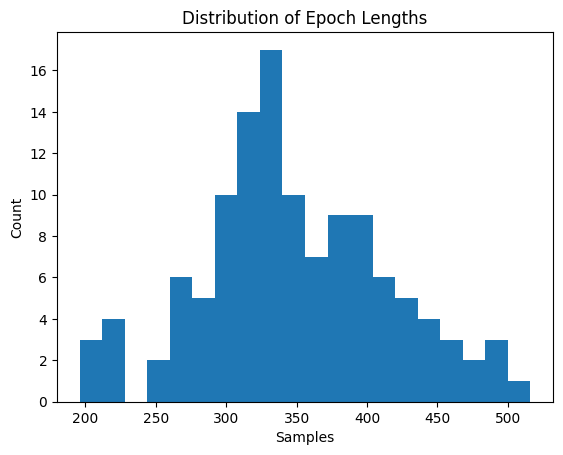

In [24]:
lengths = [e.shape[0] for e in epochs]
plt.hist(lengths, bins=20)
plt.title("Distribution of Epoch Lengths")
plt.xlabel("Samples")
plt.ylabel("Count")
plt.show()


## 3. Feature extraction & visualization

In [25]:
# --- EMG feature functions ---

def mav(x):        # Mean Absolute Value
    return np.mean(np.abs(x), axis=0)

def rms(x):        # Root Mean Square
    return np.sqrt(np.mean(x**2, axis=0))

def var_feature(x):  # Variance (power)
    return np.var(x, axis=0)

def wl(x):         # Waveform Length
    return np.sum(np.abs(np.diff(x, axis=0)), axis=0)

def ssc(x, threshold=1e-6):  # Slope Sign Changes
    diff = np.diff(x, axis=0)
    sign = np.sign(diff)
    changes = np.diff(sign, axis=0)
    return np.sum(np.abs(changes) > 0, axis=0)

def maxav(x):      # Mean of top 10% abs values
    n = x.shape[0]
    k = max(1, n // 10)
    abs_sorted = np.sort(np.abs(x), axis=0)[-k:, :]
    return np.mean(abs_sorted, axis=0)

def iemg(x):       # Integrated EMG
    return np.sum(np.abs(x), axis=0)

def zc(x, threshold=1e-6):   # Zero Crossings
    # count sign changes where amplitude change exceeds threshold
    x1 = x[:-1, :]
    x2 = x[1:, :]
    crossings = (x1 * x2) < 0
    amp_diff  = np.abs(x2 - x1) > threshold
    return np.sum(crossings & amp_diff, axis=0)

def mean_feature(x):  # Mean value
    return np.mean(x, axis=0)

def kurtosis_feature(x, eps=1e-12):  # Kurtosis per channel
    m = np.mean(x, axis=0)
    v = np.var(x, axis=0) + eps
    centered = x - m
    return np.mean(centered**4, axis=0) / (v**2 + eps)

# Keep a parallel list of names for interpretability
feature_fns = [
    mav,
    rms,
    var_feature,
    wl,
    # ssc,
    # maxav,
    iemg,
    # zc,
    # mean_feature,
    # kurtosis_feature,
]

feature_names = [
    "MAV",
    "RMS",
    "VAR",
    "WL",
    "SSC",
    "MAXAV",
    "IEMG",
    "ZC",
    "MEAN",
    "KURTOSIS",
]


In [26]:
def build_dataset_from_ninapro(epochs, labels, features):
    """
    epochs: list of (T_i, n_channels) arrays
    labels: 1D array of length n_samples
    features: list of functions (T,n_ch) -> (n_ch,)
    Returns:
        X: (n_samples, n_channels * n_features_per_channel)
        y: (n_samples,)
    """
    n_samples = len(epochs)
    n_channels = epochs[0].shape[1]
    n_feat_per_ch = len(features)

    X = np.zeros((n_samples, n_channels * n_feat_per_ch))

    for i, epoch in enumerate(epochs):
        feat_list = [f(epoch) for f in features]      # each (n_channels,)
        feats = np.stack(feat_list, axis=0).reshape(-1)
        X[i, :] = feats

    y = labels.copy()
    return X, y

X, y = build_dataset_from_ninapro(epochs, labels, feature_fns)
print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (120, 50)
y shape: (120,)


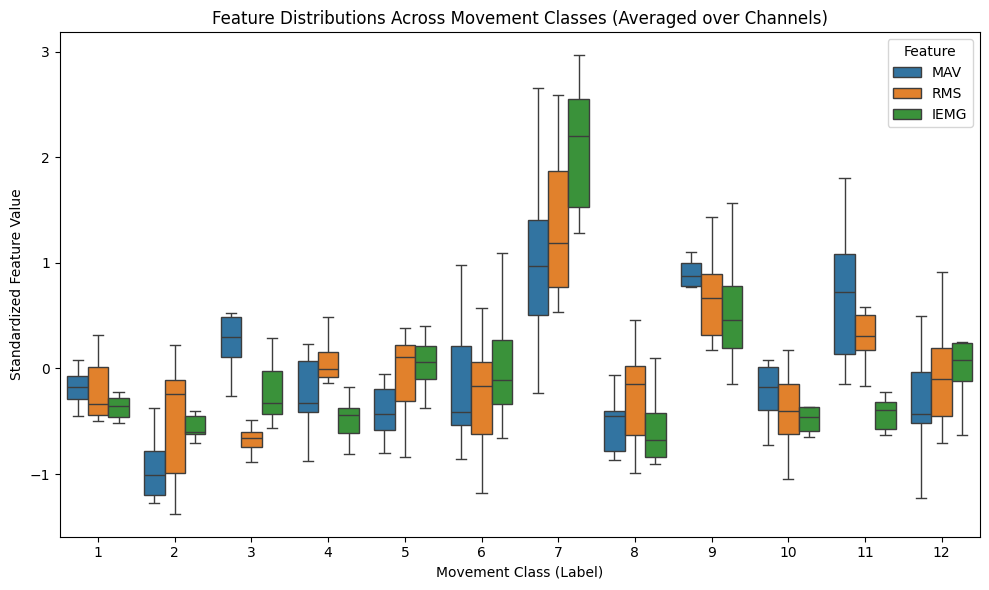

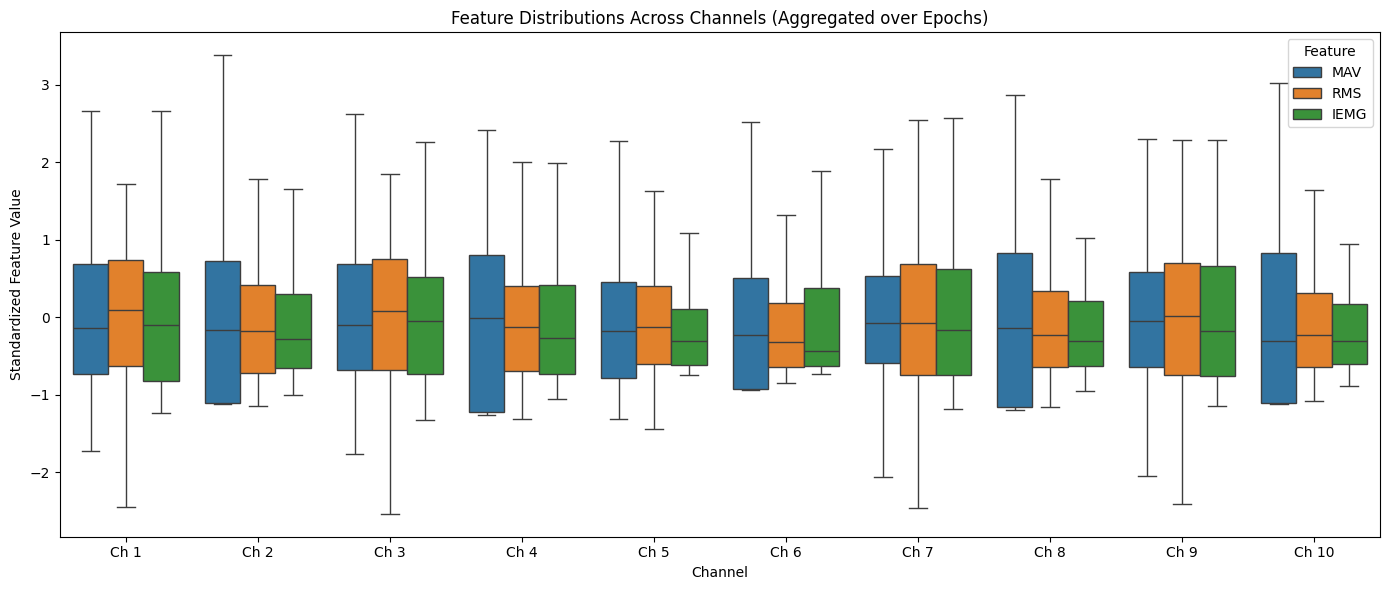

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.preprocessing import StandardScaler

# Per-feature per-channel standardization
X_scaled = StandardScaler().fit_transform(X)

# Rebuild the `df_channel` plot using X_scaled instead of X


# Setup
n_channels = 10
feature_names_used = ["MAV", "RMS", "VAR", "WL", "IEMG"]
features_to_plot = ["MAV", "RMS", "IEMG"]
feature_indices = [feature_names_used.index(name) for name in features_to_plot]

out_dir = os.path.join(os.getcwd(), "Results", "Part1")
os.makedirs(out_dir, exist_ok=True)

# --- 1. Aggregate per feature across channels (for movement class plot) ---
data_list = []

for f_idx, f_name in zip(feature_indices, features_to_plot):
    # Select all columns corresponding to that feature across channels
    cols = [ch * len(feature_names_used) + f_idx for ch in range(n_channels)]
    feature_vals = X_scaled[:, cols].mean(axis=1)  # mean across channels
    df = pd.DataFrame({
        "Value": feature_vals,
        "Label": y,
        "Feature": f_name
    })
    data_list.append(df)

df_movement = pd.concat(data_list, ignore_index=True)

# --- Plot 1: Per movement class ---
plt.close("all")
plt.figure(figsize=(10, 6))

sns.boxplot(
    data=df_movement,
    x="Label",
    y="Value",
    hue="Feature",
    showfliers=False
)

plt.title("Feature Distributions Across Movement Classes (Averaged over Channels)")
plt.xlabel("Movement Class (Label)")
plt.ylabel("Standardized Feature Value")
plt.legend(title="Feature", loc="upper right")
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "feature_distributions_by_movement_MAV_RMS_IEMG.png"), dpi=200)
plt.show()

# --- 2. Aggregate per feature across samples (for channel-wise plot) ---
data_list = []

for ch in range(n_channels):
    for f_idx, f_name in zip(feature_indices, features_to_plot):
        col_idx = ch * len(feature_names_used) + f_idx
        df = pd.DataFrame({
            "Value": X_scaled[:, col_idx],
            "Channel": f"Ch {ch+1}",
            "Feature": f_name
        })
        data_list.append(df)

df_channel = pd.concat(data_list, ignore_index=True)

# --- Plot 2: Per channel ---
plt.figure(figsize=(14, 6))
sns.boxplot(
    data=df_channel,
    x="Channel",
    y="Value",
    hue="Feature",
    showfliers=False
)

plt.title("Feature Distributions Across Channels (Aggregated over Epochs)")
plt.xlabel("Channel")
plt.ylabel("Standardized Feature Value")
plt.legend(title="Feature", loc="upper right")
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "feature_distributions_by_channel_MAV_RMS_IEMG.png"), dpi=200)
plt.show()


## 4. Gradient boosting classification

In [28]:
from sklearn.model_selection import train_test_split

# 60 % train
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=random_state
)
# 20% val 20% test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=random_state
)

scaler = StandardScaler()
X_train_z = scaler.fit_transform(X_train)
X_val_z   = scaler.transform(X_val)
X_test_z  = scaler.transform(X_test)

print("Train size:", X_train_z.shape[0])
print("Val size:", X_val_z.shape[0])
print("Test size:", X_test_z.shape[0])


Train size: 72
Val size: 24
Test size: 24


In [29]:
import pandas as pd

gb = GradientBoostingClassifier(random_state=random_state)
gb.fit(X_train_z, y_train)

y_val_pred = gb.predict(X_val_z)
print("Baseline val accuracy:", accuracy_score(y_val, y_val_pred))
print("Baseline val macro-F1:", f1_score(y_val, y_val_pred, average="macro"))

gb_results = pd.DataFrame([
    ["Baseline val accuracy:", accuracy_score(y_val, y_val_pred)],
    ["Baseline val macro-F1:", f1_score(y_val, y_val_pred, average="macro")]
])
gb_results.to_csv(os.path.join(os.getcwd(), "Results", "Part1", "part4_baseline_gradient_boosting_results.csv"), index=False)


Baseline val accuracy: 0.6666666666666666
Baseline val macro-F1: 0.6333333333333333


### Hyperparameter optimization

In [30]:
param_grid = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.05, 0.1, 0.2],
    "max_depth": [2, 3],
    "subsample": [0.7, 1.0],
    "max_features": ["sqrt", None],
}

gb_base = GradientBoostingClassifier(random_state=random_state)

grid = GridSearchCV(
    gb_base,
    param_grid,
    scoring="f1_macro",  # previously "accuracy"
    cv=5,
    n_jobs=-1
)
grid.fit(X_train_z, y_train)

print("Best params:", grid.best_params_)
print("Best CV macro-F1:", grid.best_score_)

best_gb_results = pd.DataFrame([
    ["Best params:", grid.best_params_],
    ["Best CV macro-F1:", grid.best_score_]
])
best_gb_results.to_csv(os.path.join(os.getcwd(), "Results", "Part1", "part4_best_gradient_boosting_results.csv"), index=False)

best_gb = grid.best_estimator_


Traceback (most recent call last):
  File "/home/johhan/anaconda3/envs/NX-421/lib/python3.14/site-packages/joblib/externals/loky/backend/resource_tracker.py", line 297, in main
    raise ValueError(
    ...<4 lines>...
    )
ValueError: Cannot register "REGISTER","rtype":"folder","base64_name" for automatic cleanup: unknown resource type ("L3RtcC9qb2JsaWJfbWVtbWFwcGluZ19mb2xkZXJfNjIxNzdfZTM1NTdmNDAxMzA1NDVlM2JiMTMyNDU0N2NmZjcxOGRfMzQ3ZGZmYjAyYjMwNDJiMGEyN2MxNzIxNGMyNzFhMDc="}). Resource type should be one of the following: ['noop', 'folder', 'file', 'semlock']
Traceback (most recent call last):
  File "/home/johhan/anaconda3/envs/NX-421/lib/python3.14/site-packages/joblib/externals/loky/backend/resource_tracker.py", line 297, in main
    raise ValueError(
    ...<4 lines>...
    )
ValueError: Cannot register "UNREGISTER","rtype":"semlock","base64_name" for automatic cleanup: unknown resource type ("L2xva3ktNjIxNzctbWIwN2xfYmk="}). Resource type should be one of the following: ['noop', 

Best params: {'learning_rate': 0.05, 'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 300, 'subsample': 0.7}
Best CV macro-F1: 0.7595238095238094


## 5. Performance metric & interpretation

Val accuracy: 0.75
Val macro-F1: 0.7305555555555555
Test accuracy: 0.7916666666666666
Test macro-F1: 0.7333333333333334


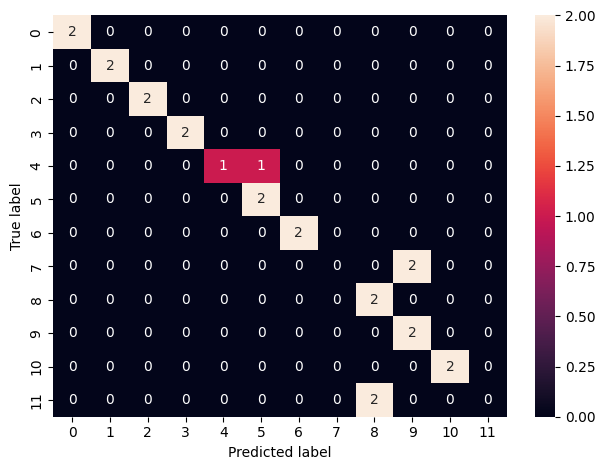

In [31]:
y_val_pred = best_gb.predict(X_val_z)
print("Val accuracy:", accuracy_score(y_val, y_val_pred))
print("Val macro-F1:", f1_score(y_val, y_val_pred, average="macro"))

y_test_pred = best_gb.predict(X_test_z)
print("Test accuracy:", accuracy_score(y_test, y_test_pred))
print("Test macro-F1:", f1_score(y_test, y_test_pred, average="macro"))

results_df = pd.DataFrame([
    ["Val accuracy:", accuracy_score(y_val, y_val_pred)],
    ["Val macro-F1:", f1_score(y_val, y_val_pred, average="macro")],
    ["Test accuracy:", accuracy_score(y_test, y_test_pred)],
    ["Test macro-F1:", f1_score(y_test, y_test_pred, average="macro")]
])
results_df.to_csv(os.path.join(os.getcwd(), "Results", "Part1", "part5_performance_metrics.csv"), index=False)

out_dir = os.path.join(os.getcwd(), "Results", "Part1")
os.makedirs(out_dir, exist_ok=True)

cm = confusion_matrix(y_test, y_test_pred)

fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt="d", ax=ax)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")

fig.tight_layout()
fig.savefig(os.path.join(out_dir, "part5_confusion_matrix.png"), dpi=200)


## 6. Feature selection / dimension reduction

In [32]:
mi = mutual_info_classif(X_train_z, y_train, random_state=random_state)
k = min(20, X_train_z.shape[1])  # top 20 or fewer if dim<20

selector = SelectKBest(mutual_info_classif, k=k)
selector.fit(X_train_z, y_train)

X_train_fs = selector.transform(X_train_z)
X_val_fs   = selector.transform(X_val_z)
X_test_fs  = selector.transform(X_test_z)

gb_fs = GradientBoostingClassifier(random_state=random_state, **grid.best_params_)
gb_fs.fit(X_train_fs, y_train)

y_test_pred_fs = gb_fs.predict(X_test_fs)
print("FS Test accuracy:", accuracy_score(y_test, y_test_pred_fs))
print("FS Test macro-F1:", f1_score(y_test, y_test_pred_fs, average="macro"))

results_df = pd.DataFrame([
    ["FS Test accuracy:", accuracy_score(y_test, y_test_pred_fs)],
    ["FS Test macro-F1:", f1_score(y_test, y_test_pred_fs, average="macro")]
])
results_df.to_csv(os.path.join(os.getcwd(), "Results", "Part1", "part6_performance_metrics_fs.csv"), index=False)


FS Test accuracy: 0.6666666666666666
FS Test macro-F1: 0.5888888888888889


In [33]:
pca = PCA(n_components=0.95, svd_solver="full")  # keep 95% variance
pca.fit(X_train_z)

X_train_pca = pca.transform(X_train_z)
X_val_pca   = pca.transform(X_val_z)
X_test_pca  = pca.transform(X_test_z)

gb_pca = GradientBoostingClassifier(random_state=random_state, **grid.best_params_)
gb_pca.fit(X_train_pca, y_train)

y_test_pred_pca = gb_pca.predict(X_test_pca)
print("PCA Test accuracy:", accuracy_score(y_test, y_test_pred_pca))
print("PCA Test macro-F1:", f1_score(y_test, y_test_pred_pca, average="macro"))
print("Number of PCA components:", X_train_pca.shape[1])

results_df = pd.DataFrame([
    ["PCA Test accuracy:", accuracy_score(y_test, y_test_pred_pca)],
    ["PCA Test macro-F1:", f1_score(y_test, y_test_pred_pca, average="macro")],
    ["Number of PCA components:", X_train_pca.shape[1]]
])
results_df.to_csv(os.path.join(os.getcwd(), "Results", "Part1", "part6_performance_metrics_pca.csv"), index=False)


PCA Test accuracy: 0.75
PCA Test macro-F1: 0.7194444444444444
Number of PCA components: 11


Text(0.5, 1.0, 'PCA Explained Variance')

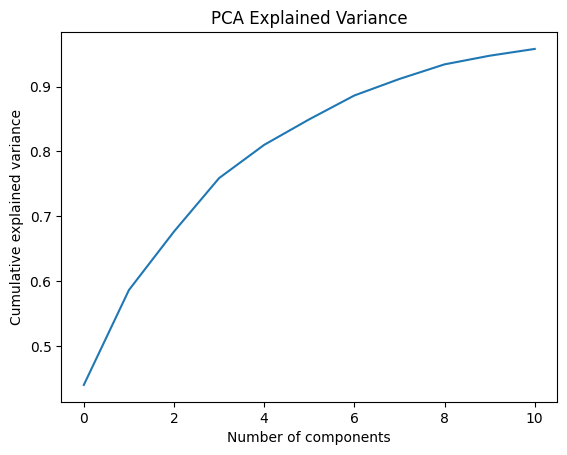

In [34]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("PCA Explained Variance")


### Permutation features importance

In [35]:
feature_fns = [mav, rms, var_feature, wl, ssc, maxav, iemg, zc, mean_feature, kurtosis_feature]
X, y = build_dataset_from_ninapro(epochs, labels, feature_fns)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=random_state)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=random_state)
scaler = StandardScaler()
X_train_z = scaler.fit_transform(X_train)
X_val_z   = scaler.transform(X_val)
X_test_z  = scaler.transform(X_test)
gb = GradientBoostingClassifier(random_state=random_state)
gb.fit(X_train_z, y_train)
y_val_pred = gb.predict(X_val_z)
print("Baseline val accuracy:", accuracy_score(y_val, y_val_pred))
print("Baseline val macro-F1:", f1_score(y_val, y_val_pred, average="macro"))

results_df = pd.DataFrame([
    ["Baseline val accuracy:", accuracy_score(y_val, y_val_pred)],
    ["Baseline val macro-F1:", f1_score(y_val, y_val_pred, average="macro")]
])
results_df.to_csv(os.path.join(os.getcwd(), "Results", "Part1", "part7_permutation_feature_results.csv"), index=False)

Baseline val accuracy: 0.6666666666666666
Baseline val macro-F1: 0.638888888888889


In [36]:
from sklearn.inspection import permutation_importance

# Compute permutation importance on the test set
result = permutation_importance(
    gb,
    X_test_z,
    y_test,
    n_repeats=30,
    random_state=random_state,
    n_jobs=-1,
    scoring="f1_macro",  # match your main metric
)

importances_mean = result.importances_mean      # shape: (n_features,)
importances_std  = result.importances_std


Traceback (most recent call last):
  File "/home/johhan/anaconda3/envs/NX-421/lib/python3.14/site-packages/joblib/externals/loky/backend/resource_tracker.py", line 297, in main
    raise ValueError(
    ...<4 lines>...
    )
ValueError: Cannot register "REGISTER","rtype":"folder","base64_name" for automatic cleanup: unknown resource type ("L3RtcC9qb2JsaWJfbWVtbWFwcGluZ19mb2xkZXJfNjIxNzdfNjc2OTE1Njc3ODYxNDI3MGIyMGUwYmU1NjQ4MGQwYmNfODhkZmIyYjM5NmM2NDI5OThjMThkNDJkMjVjYjVhYTc="}). Resource type should be one of the following: ['noop', 'folder', 'file', 'semlock']
Traceback (most recent call last):
  File "/home/johhan/anaconda3/envs/NX-421/lib/python3.14/site-packages/joblib/externals/loky/backend/resource_tracker.py", line 297, in main
    raise ValueError(
    ...<4 lines>...
    )
ValueError: Cannot register "REGISTER","rtype":"folder","base64_name" for automatic cleanup: unknown resource type ("L3RtcC9qb2JsaWJfbWVtbWFwcGluZ19mb2xkZXJfNjIxNzdfZTM1NTdmNDAxMzA1NDVlM2JiMTMyNDU0N2NmZjcxOGR

In [37]:
n_channels = epochs[0].shape[1]
n_feat_per_ch = len(feature_fns)

assert importances_mean.shape[0] == n_channels * n_feat_per_ch

imp_matrix = importances_mean.reshape(n_feat_per_ch, n_channels)  # (features, channels)

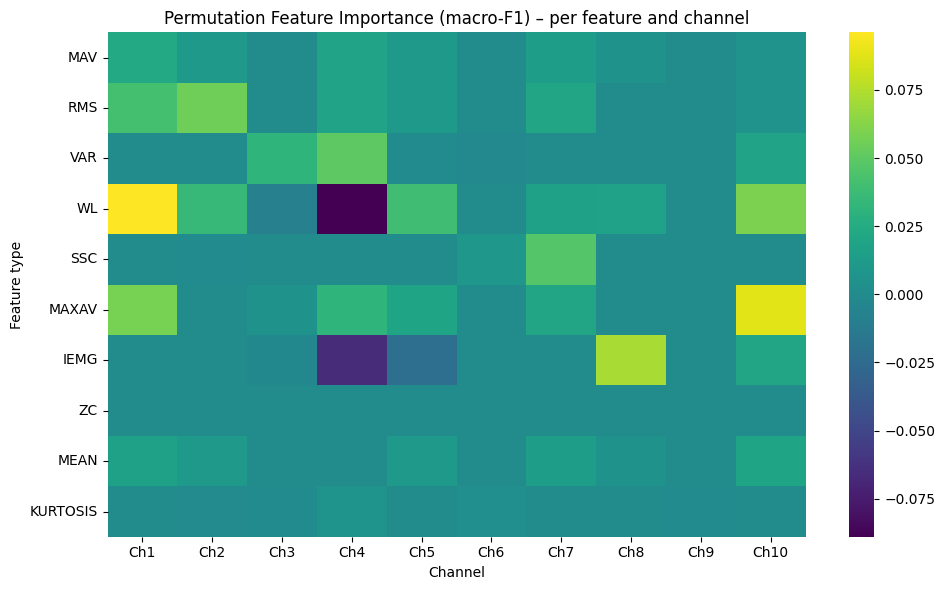

In [38]:
out_dir = os.path.join(os.getcwd(), "Results", "Part1")
os.makedirs(out_dir, exist_ok=True)

plt.figure(figsize=(10, 6))
sns.heatmap(
    imp_matrix,
    annot=False,
    cmap="viridis",
    xticklabels=[f"Ch{c+1}" for c in range(n_channels)],
    yticklabels=feature_names,
)
plt.xlabel("Channel")
plt.ylabel("Feature type")
plt.title("Permutation Feature Importance (macro-F1) – per feature and channel")
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "part7_permutation_features.png"), dpi=200)
plt.show()



In [39]:
feat_importance = imp_matrix.mean(axis=1)  # average over channels

feat_ranking = sorted(
    zip(feature_names, feat_importance),
    key=lambda x: x[1],
    reverse=True,
)

print("Average permutation importance per feature type:")
for name, score in feat_ranking:
    print(f"{name:10s}: {score:.4f}")


Average permutation importance per feature type:
MAXAV     : 0.0222
WL        : 0.0166
RMS       : 0.0151
VAR       : 0.0098
MAV       : 0.0088
MEAN      : 0.0075
SSC       : 0.0055
KURTOSIS  : 0.0008
ZC        : 0.0000
IEMG      : -0.0000


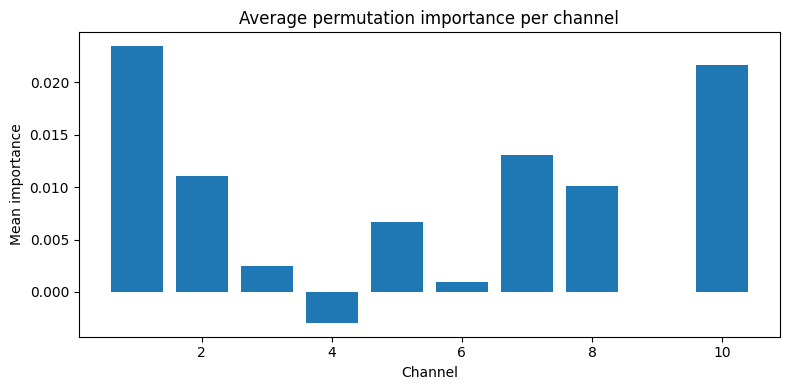

Traceback (most recent call last):
  File "/home/johhan/anaconda3/envs/NX-421/lib/python3.14/site-packages/joblib/externals/loky/backend/resource_tracker.py", line 297, in main
    raise ValueError(
    ...<4 lines>...
    )
ValueError: Cannot register "UNREGISTER","rtype":"semlock","base64_name" for automatic cleanup: unknown resource type ("L2xva3ktNjIxNzctdGxkcXUzMWY="}). Resource type should be one of the following: ['noop', 'folder', 'file', 'semlock']
Traceback (most recent call last):
  File "/home/johhan/anaconda3/envs/NX-421/lib/python3.14/site-packages/joblib/externals/loky/backend/resource_tracker.py", line 297, in main
    raise ValueError(
    ...<4 lines>...
    )
ValueError: Cannot register "UNREGISTER","rtype":"semlock","base64_name" for automatic cleanup: unknown resource type ("L2xva3ktNjIxNzctMGhrZnFnODE="}). Resource type should be one of the following: ['noop', 'folder', 'file', 'semlock']
Traceback (most recent call last):
  File "/home/johhan/anaconda3/envs/NX-42

In [40]:
channel_importance = imp_matrix.mean(axis=0)  # average over features

plt.figure(figsize=(8, 4))
plt.bar(np.arange(1, n_channels+1), channel_importance)
plt.xlabel("Channel")
plt.ylabel("Mean importance")
plt.title("Average permutation importance per channel")
plt.tight_layout()
plt.show()
